In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import regionmask
import xarray as xr

import matplotlib.pyplot as plt

from tqdm import tqdm
from joblib import dump, load

import os
import time

In [3]:
LAND_FEATURES = ['c3ann', 'c3nfx', 'c3per','c4ann', 'c4per',
 'pastr', 'primf', 'primn', 'range', 'secdf', 'secdn', 'urban']

LAND_DIFF_FEATURES = ['c3ann_diff', 'c3nfx_diff', 'c3per_diff','c4ann_diff', 'c4per_diff',
 'pastr_diff', 'primf_diff', 'primn_diff', 'range_diff', 'secdf_diff', 'secdn_diff', 'urban_diff']

# FEATURES = LAND_FEATURES + ["cell_area"]
FEATURES = LAND_DIFF_FEATURES
LABEL = 'ELUC'

TEST_YEAR = 2012

AREAS = ["EU", "SA", "US", "ALL"]
MODELS = AREAS + ["ENS"]
# Great Britain, France, Germany, Netherlands, Belgium, Switzerland, Ireland
EU_COUNTRIES = ["GB", "FR", "DE", "NL", "BE", "CH", "IE"]
# ["Brazil", "Bolivia", "Paraguay", "Peru", "Ecuador", "Colombia", "Venezuela", "Guyana", "Suriname", "Uruguay", "Argentina", "Chile"]
SA_COUNTRIES = ["BR", "BO", "PY", "PE", "EC", "CO", "VE", "GY", "SR", "UY", "AR", "CL"]
US_COUNTRIES = ["US"]


DATA_FILE_PATH = "../../data/merged_aggregated_dataset_1850_2022.zarr.zip"
UPDATE_FILE_PATH = "../../data/BLUE_LUH2-GCB2022_ELUC-committed_gridded_net_1850-2021.nc"

# The country codes are weird in regionmask
MANUAL_MAP = {
    "INDO": 360,
    "DRC": 180,
    "RUS": 643,
    "N": 578,
    "F": 250,
    "J": 388,
    "NA": 516,
    "PAL": 275,
    "J": 400,
    "IRQ": 368,
    "IND": 356,
    "IRN": 364,
    "SYR": 760,
    "ARM": 51,
    "S": 752,
    "A": 36,
    "EST": 233,
    "D": 276,
    "L": 442,
    "B": 56,
    "P": 620,
    "E": 724,
    "IRL": 372,
    "I": 380,
    "SLO": 705,
    "FIN": 246,
    "J": 392,
    "BiH": 70,
    "NM": 807,
    "KO": 383,
    "SS": 728
}

countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
countries_df = countries.to_dataframe()

codes_df = pd.read_csv("../mvp/data/gcb/conversion/codes.csv")

# Replace all the bad codes with their real ones
for i in range(len(countries_df)):
    old_abbrev = countries_df.iloc[i]["abbrevs"]
    if old_abbrev in MANUAL_MAP.keys() and MANUAL_MAP[old_abbrev] in codes_df["Numeric code"].unique():
        countries_df.iloc[i]["abbrevs"] = codes_df[codes_df["Numeric code"] == MANUAL_MAP[old_abbrev]]["Alpha-2 code"].iloc[0]

device = "mps"

### Data Processing

In [4]:
def import_data(path, update_path):
    raw = xr.open_zarr(path, consolidated=True)

    # Get updated ELUC
    if update_path:
        eluc = xr.open_dataset(update_path)
        raw = raw.drop_vars(["ELUC", "cell_area"])
        raw = raw.merge(eluc)

    # Shift actions back a year
    raw[LAND_DIFF_FEATURES] = raw[LAND_DIFF_FEATURES].shift(time=-1)

    # Old time shifting
    # raw['ELUC'] = raw['ELUC'].shift(time=1)
    # raw['ELUC_diff'] = raw['ELUC_diff'].shift(time=1)
    # raw['time'] = raw.time - 1
    # assert(list(np.unique(raw.time)) == list(range(1849, 2022)))
    # mask = raw["ELUC_diff"].isnull().compute()
    # raw = raw.where(~mask, drop=True)

    country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask(raw)
    raw["country"] = country_mask
    return raw


def subset_countries(df, countries):
    """
    Subsets dataframe by country list
    """
    if countries:
        idx = countries_df[countries_df["abbrevs"].isin(countries)].index.values
        return df[df["country"].isin(idx)].copy()
    return df.copy()


def da_to_df(da, start_year=None, end_year=None, countries=None):
    df = da.to_dataframe()
    df = df.dropna()
    df = df.reorder_levels(["time", "lat", "lon"]).sort_index()
    df['country_name'] = countries_df.loc[df['country'], 'names'].values
    if start_year:
        df = df.loc[start_year:]
    if end_year:
        df = df.loc[:end_year]
    if countries:
        df = subset_countries(df, countries)
        
    return df

In [5]:
print("Loading data...")
raw = import_data(DATA_FILE_PATH, UPDATE_FILE_PATH)

Loading data...


/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of c

In [6]:
df = da_to_df(raw)
df.head()

ELUC_diff         c3ann    c3ann_diff         c3nfx  \
time lat     lon                                                               
1851 -55.375 -69.375  1.585186e-04  1.529372e-07 -1.466177e-09  0.000000e+00   
             -69.125 -1.669832e-09  6.256299e-08 -4.925624e-10  8.209591e-09   
             -68.875  3.134616e-07  2.541674e-08  3.165289e-08  0.000000e+00   
             -68.625 -2.126626e-08  6.788947e-08 -7.737526e-10  0.000000e+00   
             -68.375 -8.974894e-09  1.061018e-06 -5.096126e-09  0.000000e+00   

                        c3nfx_diff         c3per    c3per_diff         c4ann  \
time lat     lon                                                               
1851 -55.375 -69.375  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
             -69.125 -6.463452e-11  1.742937e-08 -1.372218e-10  8.359032e-09   
             -68.875  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
             -68.625  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
             -68.375  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

                        c4ann_diff  c4per  ...     secdf    secdf_diff  \
time lat     lon                           ...                           
1851 -55.375 -69.375  0.000000e+00    0.0  ...  0.012612  1.048539e-04   
             -69.125 -6.581136e-11    0.0  ...  0.001253 -1.396984e-09   
             -68.875  0.000000e+00    0.0  ...  0.000000  0.000000e+00   
             -68.625  0.000000e+00    0.0  ...  0.000000  0.000000e+00   
             -68.375  0.000000e+00    0.0  ...  0.000000  0.000000e+00   

                         secdn    secdn_diff  urban  urban_diff          ELUC  \
time lat     lon                                                                
1851 -55.375 -69.375  0.000000  0.000000e+00    0.0         0.0  4.283220e-03   
             -69.125  0.000000  0.000000e+00    0.0         0.0 -3.430041e-07   
             -68.875  0.000034 -3.637979e-12    0.0         0.0  3.217266e-06   
             -68.625  0.000038  5.940819e-09    0.0         0.0 -7.565677e-08   
             -68.375  0.000044 -3.637979e-12    0.0         0.0 -3.761452e-07   

                         cell_area  country  country_name  
time lat     lon                                           
1851 -55.375 -69.375  43908.949219     10.0         Chile  
             -69.125  43908.949219     10.0         Chile  
             -68.875  43908.949219     10.0         Chile  
             -68.625  43908.949219     10.0         Chile  
             -68.375  43908.949219     10.0         Chile  

[5 rows x 31 columns]

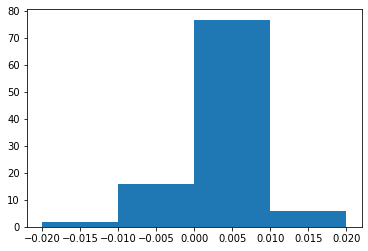

In [7]:
plt.hist(df["ELUC"], bins=[-0.02, -0.01, 0, 0.01, 0.02], density=True)
plt.show()

In [8]:
countries_dict = dict(zip(AREAS, [EU_COUNTRIES, SA_COUNTRIES, US_COUNTRIES, None]))
print(countries_dict)

data_dict = dict()
for area in countries_dict.keys():
    data_dict[area] = subset_countries(df, countries_dict[area])

{'EU': ['GB', 'FR', 'DE', 'NL', 'BE', 'CH', 'IE'], 'SA': ['BR', 'BO', 'PY', 'PE', 'EC', 'CO', 'VE', 'GY', 'SR', 'UY', 'AR', 'CL'], 'US': ['US'], 'ALL': None}


### Ensemble

In [9]:
class SuperPredictor():
    def __init__(self, models):
        self.models = models

    def predict(self, X):
        preds = []
        for model in self.models:
            preds.append(model.predict(X))
        preds_np = np.stack(preds, axis=0)
        avgs = preds_np.mean(axis=0)
        return avgs

### Neural Net

In [10]:
class NeuralNet():

    class CustomDS(Dataset):
        def __init__(self, X_train, y_train):
            super().__init__()
            self.X = torch.tensor(X_train.to_numpy()).to(device)
            self.y = torch.tensor(y_train.to_numpy()).to(device)

        def __len__(self):
            return len(self.X)

        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]


    def __init__(self, in_size, hidden_size): 
        # Model
        self.model = torch.nn.Sequential(
            torch.nn.Linear(in_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, 1)
        )
        self.model.to(device)

    def fit(self, X_train, y_train, test=None, epochs=10, batch_size=2048, lr=1e-2, momentum=0.9, weight_decay=1e-3):
        train_ds = self.CustomDS(X_train, y_train)
        train_dl = DataLoader(train_ds, batch_size, shuffle=True)

        if test:
            X_test, y_test = test
            test_ds = self.CustomDS(X_test, y_test)
            test_dl = DataLoader(test_ds, batch_size, shuffle=True)

        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        loss_fn = torch.nn.L1Loss()
        # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, 0.1)

        writer = SummaryWriter(f"runs/{len(os.listdir('runs'))}")

        
        step = 0
        test_step = 0
        for epoch in range(epochs):
            self.model.train()
            for X, y in tqdm(train_dl):
                optimizer.zero_grad()
                out = self.model(X).squeeze()
                loss = loss_fn(out, y)
                writer.add_scalar("loss", loss.item(), step)
                step += 1
                loss.backward()
                optimizer.step()
            # scheduler.step()

            if test_dl:
                total = 0
                self.model.eval()
                with torch.no_grad():
                    for X, y in tqdm(test_dl):
                        out = self.model(X).squeeze()
                        loss = loss_fn(out, y)
                        writer.add_scalar("test_loss", loss.item(), test_step)
                        test_step += 1
                        
                        total += loss.item() * y.shape[0]

                print(f"epoch {epoch} mae {total / len(test_ds)}")

    def predict(self, X_test):
        X = torch.tensor(X_test.to_numpy()).to(device)
        with torch.no_grad():
            self.model.eval()
            return self.model(X).squeeze().cpu().numpy()

In [11]:
# Ideas:
# Play with test year cutoff
# Test set sample - does the distribution change a lot over time?
# Could try different sizes
# Learning rate scheduler
time_test = False
nn_feats = LAND_FEATURES + LAND_DIFF_FEATURES
net = NeuralNet(len(nn_feats),
                len(nn_feats) // 2, 
                epochs=10)

net_data = data_dict["ALL"].sample(frac=0.01, random_state=42)
if time_test:
    train, test = net_data.loc[:2012], net_data.loc[2012:]
else:
    train, test = train_test_split(net_data, test_size=0.2, random_state=42, shuffle=True)
    
X_train, y_train = train[nn_feats], train["ELUC"]
X_test, y_test = test[nn_feats], test["ELUC"]

net.fit(X_train, y_train, (X_test, y_test))


  0%|          | 0/162 [00:00<?, ?it/s]/Users/964840/anaconda3/envs/leaf/lib/python3.10/site-packages/torch/autograd/__init__.py:204: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 41/41 [00:03<00:00, 10.76it/s]


epoch 0 mae 0.13232546445150428


100%|██████████| 41/41 [00:03<00:00, 11.21it/s]


epoch 1 mae 0.12238975209845107


100%|██████████| 41/41 [00:03<00:00, 10.94it/s]


epoch 2 mae 0.10676416018017366


100%|██████████| 41/41 [00:03<00:00, 11.12it/s]


epoch 3 mae 0.0922380927267876


100%|██████████| 41/41 [00:03<00:00, 11.17it/s]


epoch 4 mae 0.08211208181262213


100%|██████████| 41/41 [00:03<00:00, 11.24it/s]


epoch 5 mae 0.07116248473601375


100%|██████████| 41/41 [00:03<00:00, 10.86it/s]


epoch 6 mae 0.07011499760305753


100%|██████████| 41/41 [00:03<00:00, 10.91it/s]


epoch 7 mae 0.0656016996529807


100%|██████████| 41/41 [00:03<00:00, 11.32it/s]


epoch 8 mae 0.06554782893204443


100%|██████████| 41/41 [00:03<00:00, 10.96it/s]

epoch 9 mae 0.06364993655999594


### Model Training

In [ ]:
def train_sk(df, model_type, features, params={}, test_year=TEST_YEAR, save=False):
    """
    Trains linear regression model
    """
    train = df.loc[:test_year]
    test = df.loc[test_year:]
    X_train = train[features]
    y_train = train[LABEL]
    X_test = test[features]
    y_test = test[LABEL]

    if model_type == "linreg":
        model = LinearRegression(n_jobs=-1, **params)
    elif model_type == "forest":
        model = RandomForestRegressor(n_jobs=-1, **params)
    else:
        model = NeuralNet(len(features), (len(features) + 1) // 2, batch_size=4096, epochs=2, **params)

    s = time.time()
    model.fit(X_train, y_train)
    e = time.time()
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)

    if save:
        dump(model, f"saved/{save}.joblib")

    return model, mae, e - s

In [ ]:
nn_dict = dict()
for area in data_dict.keys():
    model, mae, t = train_sk(data_dict[area], "nn", LAND_FEATURES + ["cell_area"] + LAND_DIFF_FEATURES)
    nn_dict[area] = model
    print(f"{area} : {mae} : {t}")

nn_models = list(nn_dict.values())
super_nn = SuperPredictor(nn_models)
nn_dict["ENS"] = super_nn

torch.Size([437886, 25])


100%|██████████| 107/107 [00:18<00:00,  5.64it/s]


EU : 0.4076438844203949 : 38.998635053634644
torch.Size([3918942, 25])


100%|██████████| 957/957 [02:53<00:00,  5.52it/s]


SA : 0.2520342469215393 : 343.4472460746765
torch.Size([2846988, 25])


100%|██████████| 696/696 [02:06<00:00,  5.52it/s]


US : 0.09549366682767868 : 250.30956411361694
torch.Size([39209670, 25])


100%|██████████| 9573/9573 [30:13<00:00,  5.28it/s]


ALL : 0.14587053656578064 : 3566.11097407341


In [ ]:
linreg_dict = dict()
for area in data_dict.keys():
    model, mae, t = train_sk(data_dict[area], "linreg", LAND_DIFF_FEATURES, save=f"{area}-linreg")
    linreg_dict[area] = model
    print(f"{area} : {mae} : {t}")

linreg_models = list(linreg_dict.values())
super_linreg = SuperPredictor(linreg_models)
linreg_dict["ENS"] = super_linreg

EU : 0.03312671184539795 : 0.16405510902404785
SA : 0.15485286712646484 : 0.7999930381774902
US : 0.03451376035809517 : 0.4849739074707031
ALL : 0.07230156660079956 : 10.302732229232788


In [ ]:
forest_dict = dict()
for area in data_dict.keys():
    start_year = 1982
    if area == "ALL":
        start_year = 2010
    model, mae, t = train_sk(data_dict[area].loc[start_year:], "forest", LAND_FEATURES + ["cell_area"] + LAND_DIFF_FEATURES, save=f"{area}-forest")
    forest_dict[area] = model
    print(f"{area} : {mae} : {t}")

forest_models = list(forest_dict.values())
super_forest = SuperPredictor(forest_models)
forest_dict["ENS"] = super_forest

EU : 0.03122097690954875 : 17.572288990020752
SA : 0.07220671190398535 : 311.5672650337219
US : 0.019661567357595097 : 114.83990669250488
ALL : 0.054929612174459574 : 262.7167739868164


### Model Eval

In [ ]:
def eval_sk(model, df, features, test_year=TEST_YEAR, end_year=None):
    if not test_year:
        test = df
    else:
        test = df.loc[test_year:]
    X_test = test[features]
    y_test = test[LABEL]
    
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)

    return mae

def acc_graph(linreg_dict, forest_dict, data_dict, test_year=TEST_YEAR, save=None):
    for area in AREAS:
        linreg_maes = []
        forest_maes = []
        for t in range(test_year, 2022):
            linreg_mae = eval_sk(linreg_dict[area], data_dict[area].loc[t], LAND_DIFF_FEATURES, test_year=None)
            forest_mae = eval_sk(forest_dict[area], data_dict[area].loc[t], LAND_FEATURES + ["cell_area"] + LAND_DIFF_FEATURES, test_year=None)
            linreg_maes.append(linreg_mae)
            forest_maes.append(forest_mae)

        plt.plot(range(TEST_YEAR, 2022), linreg_maes, label=f"{area} linreg", marker="o")
        plt.plot(range(TEST_YEAR, 2022), forest_maes, label=f"{area} forest", marker="x")

    ax = plt.gca()
    ax.set_ylim([0, 0.25])
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid()
    plt.xlabel("Year")
    plt.ylabel("MAE")
    plt.title("MAE over Time for All Models")

    if save:
        plt.savefig(save, bbox_inches="tight", transparent=False)

    plt.show()

In [ ]:
linreg_grid = np.zeros((len(MODELS), len(AREAS)))
forest_grid = np.zeros(linreg_grid.shape)
for i in range(len(MODELS)):
    model_name = MODELS[i]
    for j in range(len(AREAS)):
        data_area = AREAS[j]
        linreg_mae = eval_sk(linreg_dict[model_name], data_dict[data_area], LAND_DIFF_FEATURES)
        forest_mae = eval_sk(forest_dict[model_name], data_dict[data_area], LAND_FEATURES + ["cell_area"] + LAND_DIFF_FEATURES)

        linreg_grid[i, j] = linreg_mae
        forest_grid[i, j] = forest_mae

print(MODELS)
print(linreg_grid)
print(forest_grid)

['EU', 'SA', 'US', 'ALL', 'ENS']
[[0.03312671 0.25698057 0.17198437 0.22040431]
 [0.14224406 0.15485287 0.06476258 0.11095934]
 [0.14021051 0.1466895  0.03451376 0.07200481]
 [0.14098775 0.15198237 0.03655225 0.07230157]
 [0.10547955 0.16505462 0.06981746 0.10059017]]
[[0.03122098 0.23995696 0.11861614 0.22561084]
 [0.17421035 0.07220671 0.04592406 0.10744972]
 [0.15534629 0.18813189 0.01966157 0.11396047]
 [0.09920544 0.08690793 0.02566942 0.05492961]
 [0.10228721 0.12722926 0.04442375 0.08311628]]


In [ ]:
for area in AREAS:
    print(len(data_dict[area]))

462213
4136661
3005154
41387985


In [ ]:
for i in range(len(forest_grid)):
    line = ""
    for j in range(len(forest_grid[0])):
        line += f"{round(forest_grid[i, j], 4)} & "

    print(line)

0.0312 & 0.24 & 0.1186 & 0.2256 & 
0.1742 & 0.0722 & 0.0459 & 0.1074 & 
0.1553 & 0.1881 & 0.0197 & 0.114 & 
0.0992 & 0.0869 & 0.0257 & 0.0549 & 
0.1023 & 0.1272 & 0.0444 & 0.0831 & 


In [ ]:
# acc_graph(linreg_dict, forest_dict, data_dict, save="saved/mae.jpg")

### Experiment on extreme ELUC

In [ ]:
mean = df["ELUC"].mean()
std = df["ELUC"].std()
extreme_df = df[(df["ELUC"] >= mean + std * 2) | (df["ELUC"] <= mean - std * 2)]
print(eval_sk(linreg_dict["ALL"], extreme_df, LAND_DIFF_FEATURES))
print(eval_sk(forest_dict["ALL"], extreme_df, LAND_FEATURES + ["cell_area"] + LAND_DIFF_FEATURES))

0.77432704
0.6465967089249522
